<a href="https://colab.research.google.com/github/SBShimm/Aiffel/blob/master/exploration/Exploration11_SB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 이미지 생성  
DBGAN 모델을 이용하여 CIFAR-10 데이터를 생성하는 모델을 만들어 봅시다.

일단 필요한 패키지, 모듈을 업로드합니다.

In [ ]:
!pip list | grep -E 'imageio|Pillow'

imageio                       2.9.0
Pillow                        7.1.2


In [ ]:
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## 1. 데이터셋 구성하기  
일단 CIFAR-10 데이터를 가져옵시다.

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train, _), (test, _) = cifar10.load_data()

train.shape

(50000, 32, 32, 3)

가져온 CIFAR-10 데이터는 -1~1의 값으로 정규화를 해줍니다.

In [ ]:
train_x = (train - 127.5) / 127.5

In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


성공적으로 최솟값은 -1, 최댓값은 1로 정규화가 진행되었습니다.  
이제 불러온 데이터를 확인해 보겠습니다.

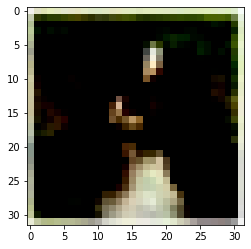

In [ ]:
plt.imshow((train_x[500]).reshape(32, 32, 3))
plt.show()

-1~1로 정규화를 해서 그런지 살짝 뭉개져 보이긴 하지만.. 음수 부분은 전부 0으로 취급하는 건가 싶습니다.

(원래사진)

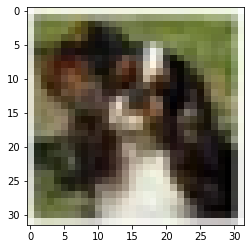

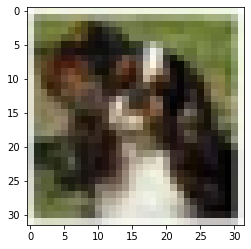

In [ ]:
plt.imshow(((train_x[500] + 1) / 2).reshape(32, 32, 3))
plt.show()
plt.imshow(train[500].reshape(32, 32, 3))
plt.show()

음수가 없도록 +1을 해주고 2로 나누어주니 원본과 동일한 이미지를 출력해주네요.  
이제 데이터를 모델에서 편하게 사용하도록 데이터셋 객체로 만들어 줍니다.  
BUGGER_SIZE는 50000(데이터 수), BATCH_SIZE 256으로 설정합니다.

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 2. 모델 구현하기
다음은 모델을 생성합니다.  
GAN에서는 생성자, 판별자 두가지 네트워크를 생성하여야 합니다.
생성자는 데이터를 만들어내고 판별자는 생성자가 만들어낸 데이터가 찐인지 짭인지 판단하여 출력합니다.  
MNIST FASHION 데이터셋은 크기가 28x28이었어서 출력을 그렇게 맞췄는데 CIFAR-10은 32x32입니다.  
거기에 맞춰서 레이어 크기를 조정해 주겠습니다.


In [ ]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

다음은 생성자에 입력할 노이즈를 만들어냅니다 Input 형상을 1, 100으로 잡았기 때문에 거기에 맞춰 노이즈를 생성합니다.  
tf.random.normal은 가우시안 분포대로 랜덤한 값을 벡터로 만들어줍니다.

In [ ]:
noise = tf.random.normal([1, 100])

학습 전의 생성자에 노이즈를 넣으면 아래와 같은 그림이 나옵니다.

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

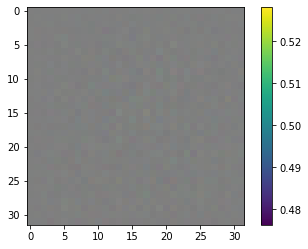

In [ ]:
plt.imshow((generated_image[0] + 1) / 2)
plt.colorbar()
plt.show()

아직 학습 전이라서 그냥 흑백사진입니다.  
다음은 판별자를 만들어 줍시다.  
그림 크기에 맞게 input_shape만 수정해 주면 됩니다.

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

손실함수는 교차 엔트로피 함수를 사용합니다.  
생성자와 판별자의 손실함수 및 정확도 측정을 위해 함수들을 만들어 줍시다.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

다음은 최적화 함수입니다. 여기서는 Adam 최적화 기법을 사용합니다.  
생성자와 판별자는 따로 학습을 진행하기 때문에 각각 생성해 주어야 합니다.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

이제 학습 중간중간 생성자가 잘 학습하고 있는지 확인하기 위해 중간중간 샘플을 확인하기 위해 고정된 노이즈로 seed를 생성해 둡니다.

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

이제 훈련을 위한 함수를 생성합니다. train_step은 한 미니 배치당 진행할 학습 과정입니다.  
@tf.function 데코레이터는 직접 session을 열고 닫는 번거로운 과정을 할 필요 없이 내부에서 처리해 줍니다. 또한, 함수에 입력된 입력을 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환됩니다.

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

아래는 일전 간격으로 학습 현황을 볼 수 있도록 샘픙르 생성하는 함수입니다.  
아까 생성한 고정된 노이즈의 seed를 사용하기 때문에 얼마나 나아지고 있는지를 확인할 수 있습니다.

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1) / 2)
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/Colab/Datasets/dcgan_newimage/cifar-10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/Colab/Datasets/dcgan_newimage/cifar-10/train_history/training_history_{:04d}.png'
                    .format(epoch))
    plt.show()

다음은 모델의 학습상태를 checkpoint로 저장하여 예상치 못한 문제로 잃어버리지 않도록 합시다.

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Colab/Datasets/dcgan_newimage/cifar-10/training_checkpoints/'

checkpoint_prefix = checkpoint_dir + "ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

여태 만들었던 함수들을 모두 활용하여 train 함수를 만들어 주도록 하겠습니다.

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

## 3. 학습시키기
이제 학습을 시켜봅시다. 

In [ ]:
save_every = 5
EPOCHS = 66

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

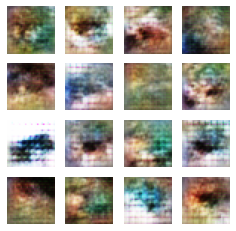

Time for training : 595 sec


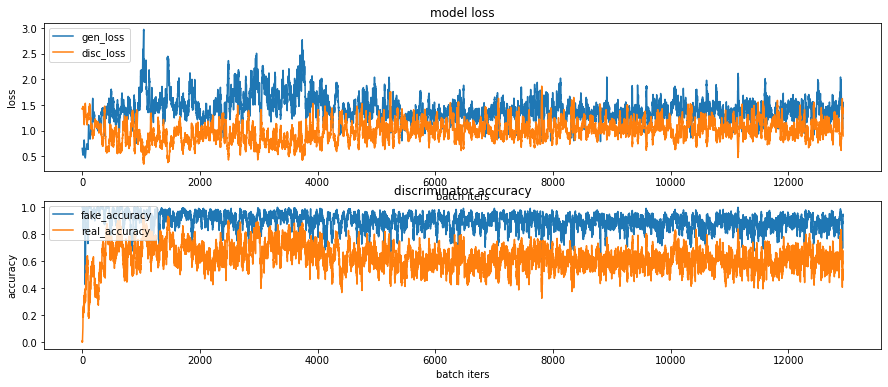

CPU times: user 10min 15s, sys: 13.1 s, total: 10min 29s
Wall time: 9min 57s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

형체를 알아볼 수 없는 아이들이 생성됩니다... 그래프도 뒤죽박죽이네요.  
아래 코드는 캡쳐된 학습 진행 사진들을 gif파일로 만들어 학습과정을 확인할 수 있도록 해줍니다.

In [ ]:
anim_file = '/content/drive/MyDrive/Colab/Datasets/dcgan_newimage/cifar-10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Colab/Datasets/dcgan_newimage/cifar-10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/Colab/Datasets/dcgan_newimage/cifar-10/cifar10_dcgan.gif

-rw------- 1 root root 2602190 Aug 26 06:57 /content/drive/MyDrive/Colab/Datasets/dcgan_newimage/cifar-10/cifar10_dcgan.gif


노이즈를 새로 생성하여 생성자 모델을 통해 이미지를 생성해 봅시다.

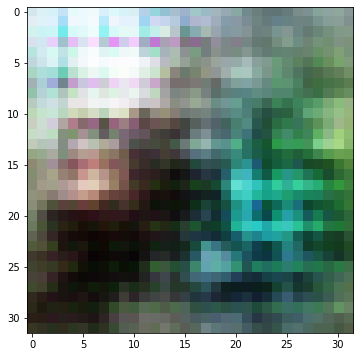

In [ ]:
# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()

아직은 그림이 흐릿하게 그려집니다...  
모델 구조 등등을 고쳐서 조금 더 나은 학습을 할 수 있도록 만들어 봅시다.

## 4. 훈련 과정 개선하기  

In [ ]:
def make_generator_model_edit():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(192, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(96, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
def make_discriminator_model_edit():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(96 , (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(192, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
generator = make_generator_model_edit()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_3 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 192)        1228800   
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 192)       

In [ ]:
discriminator = make_discriminator_model_edit()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 96)        7296      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16, 16, 96)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 96)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 192)         460992    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 192)         0         
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 192)         0         
                                                                 
 flatten_1 (Flatten)         (None, 12288)            

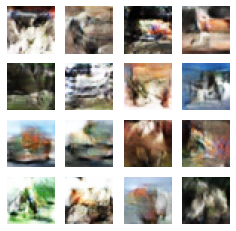

Time for training : 6898 sec


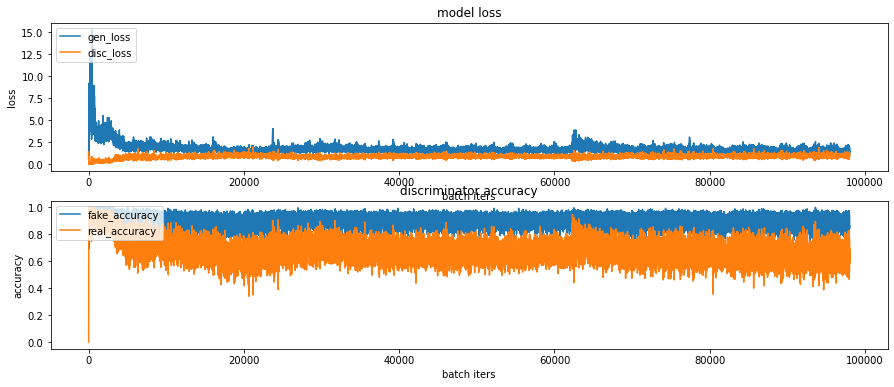

CPU times: user 1h 57min 25s, sys: 1min 42s, total: 1h 59min 8s
Wall time: 1h 55min 3s


In [ ]:
%%time
train(train_dataset, 500, save_every)

Learning Rate, 모델 구조, Batch Size, Epoch 등등을 변경해가면서 테스트해봤는데 반복수를 늘리는 것이 더 그림이 그럴싸하게 보이게 하는 것 같다.  
그래프는 좋은 모습을 보이더라도 그림이 알아볼 수가 없게 그려지는 경우가 많더라..
다른 수정에서는 썩 좋은결과를 얻을 수가 없었다.  
이것도 fake accuracy는 좀처럼 내려가지가 않는다. Epoch을 더 늘리면 어떻게될까 싶기도 한데 학습이 너무 오래 걸려서 많은 시도를 하기가 부담스럽다.

처음에 Learning rate를 0.01 변경했다가 깜박하고 다양한 변화를 줬었는데 처음엔 좀 잘되나 싶더나 한가지나 두가지 색만 생성하는 모델이 되어버렸다. accuracy그래프는 덮어씌워져서 사라져 버렸는데 처음엔 좀 괜찮다가 fake, real accuracy 모두 거의 1에 수렴하는 아주 좋지 않은 결과가 되었다.  
그 이후에 실행했던 다른 변화들도 Learning rate 때문인지 30에폭쯤 지나면 전부 검은색을 뽑거나 노란색, 흰색으로 모든 화면을 덮는 이미지가 생성되면서 학습이 진행되지가 않았다. 

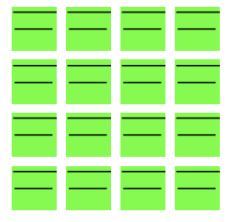

학습과정을 gif파일로 한번 살펴보자.

In [ ]:
anim_file = '/content/drive/MyDrive/Colab/Datasets/dcgan_newimage/cifar-10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Colab/Datasets/dcgan_newimage/cifar-10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/Colab/Datasets/dcgan_newimage/cifar-10/cifar10_dcgan.gif

-rw------- 1 root root 3792504 Aug 26 09:07 /content/drive/MyDrive/Colab/Datasets/dcgan_newimage/cifar-10/cifar10_dcgan.gif


gif파일을 올리려니까 코랩 페이지가 Out of memory라며 튕겨버린다..  
말로 설명해 보자면 학습이 잘되는듯 하다가 예전에 돌렸던 이미지들을 안지우고 해버려서 다른 학습 데이터들과 짬뽕이 된 gif 파일이 만들어졌다.  
몇 번 모델을 변경한 이후로는 정신이 없어서 신경을 잘 쓰지 못했다...

## 5. 회고
1. 학습 하나하나가 너무 오래걸려서 하다가 지쳐버렸다 learning rate를 처음에 변경했던걸 깜박해서 영문도 모르고 왜 이미지가 이상하게 학습되나 몰랐는데.. 너무 많은 시간을 낭비해 버렸다.
2. 여러 블로그를 통해 개선 모델들을 따라해 봤는데 그래프는 좋은데 이미지가 이상한 경우가 많았다.  